In [18]:
import numpy as np
import pandas as pd
import pickle
import matplotlib
import scipy
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
from sklearn import linear_model
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from scipy import stats
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# trims a dataframe of outliers of the conditional distribution of y given x
def trimDF(df,x,y,percentiles,bins,binwidth):
    for i in range (len(bins)-1):
        data = df.loc[abs(df[x]-bins[i])<binwidth[i]]
        if not data.empty:
            df = df.drop(data.loc[(data[y]<np.percentile(data[y], percentiles[0]))].index.values)
            df = df.drop(data.loc[(data[y]>np.percentile(data[y], percentiles[1]))].index.values)
    return df



In [3]:
def scaleColumns(df, cols_to_scale):
    for col in cols_to_scale:
        df[col] = pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame(dfTest[col])),columns=[col])
    return df

In [10]:
def reduce_func(D_chunk, start):
    return np.histogram(D_chunk)

In [4]:
# sets up a Sobol sampling grid and finds one match in df within a distance of each Sobol grid sample
def sobolSampler(df,featureColumns,leafSize,randSeed,numDim,pairwiseDist):
    
    # sobol sampling with number of samples determined by https://www.sciencedirect.com/science/article/abs/pii/S0378475406002382
    sobel = scipy.stats.qmc.Sobol(len(featureColumns),seed=randSeed).random_base2(m=np.uint8(np.ceil(np.log2(np.power(pairwiseDist,-numDim)))))
    
    # we match the sobol samples with our data using KDtrees
    sobelTree = scipy.spatial.KDTree(sobel, leafsize=leafSize, compact_nodes=True, copy_data=False, balanced_tree=True, boxsize=None)
    sampleTree = scipy.spatial.KDTree(scaledSample[featureColumns], leafsize=leafSize, compact_nodes=True, copy_data=False, balanced_tree=True, boxsize=None)
    indexes = sobelTree.query_ball_tree(sampleTree, r=1.41*pairwiseDist,p=1)
    
    # we only keep sobol samples with a match
    indexes = [ele for ele in indexes if ele != []]
    index = []
    
    # return a dataframe with the first match to each sobol sample 
    newsamples  = scaledSample.iloc[0:1]
    for i in range(len(indexes)):
        index.append(indexes[i][0])
    index = list(set(index))
    
    return scaledSample.iloc[index]


In [5]:
# does lars regression , displays path and returns results
def showLarsPath(X,y):
    
    alphas, active, coefs = linear_model.lars_path(X=X,y=y, method="lars", verbose=True)
    xx = np.sum(np.abs(coefs.T), axis=1)
    xx /= xx[-1]
    plt.plot(xx, coefs.T)
    ymin, ymax = plt.ylim()
    plt.vlines(xx, ymin, ymax, linestyle="dashed")
    plt.xlabel("|coef| / max|coef|")
    plt.ylabel("Coefficients")
    plt.title("LASSO Path")
    plt.axis("tight")
    plt.show()
    
    return alphas, active, coefs

In [6]:
file_name = ['LUTinputLC0XB36cal', 'LUTinputLC0XB45cal','LUTinputMOD09cal' ,'LUTinputLC0XLatcal', \
             'LUTinputLC0XLoncal','LUToutputLC0Xcal','YearLC0Xcal','MonthLC0Xcal', \
             'DayLC0Xcal','PathLC0Xcal','RowLC0Xcal']

dataset = []
DataList = []
count = 0

for name in file_name:
    dataset.append(f'/home/richard_fernandes/LandsatMODIS/{name}')

for name_dataset in dataset:
    with open(f'{name_dataset}', 'rb') as fp1:
        objs = []
        while 1:
            try:
                objs.append(pickle.load(fp1))
            except EOFError:
                break
        DataList = [item for sublist in objs for item in sublist]
        
    if count == 0:
        LUTB36_list = DataList
    elif count == 1:
        LUTB45_list = DataList
    elif count == 2:
        LUTMOD09_list = DataList
    elif count == 3:
        LUTLat = DataList
    elif count == 4:
        LUTLon = DataList
    elif count == 5:
        LUToutput_list = DataList
    elif count == 6:
        LUTyear = DataList
    elif count == 7:
        LUTmonth = DataList
    elif count == 8:
        LUTday = DataList
    elif count == 9:
        LUTpath = DataList
    elif count == 10:
        LUTrow = DataList
    
    count = count + 1
        
print('LUTB36_list:', len(LUTB36_list))
print('LUTB45_list:', len(LUTB45_list))
print('LUTMOD09_list:', len(LUTMOD09_list))
print('LUTLat:', len(LUTLat))
print('LUTLon:', len(LUTLon))
print('LUToutput_list:', len(LUToutput_list))
print('LUTyear:', len(LUTyear))
print('LUTmonth:', len(LUTmonth))
print('LUTday:', len(LUTday))
print('LUTpath:', len(LUTpath))
print('LUTrow:', len(LUTrow))


LUTB36_list: 6792058
LUTB45_list: 6792058
LUTMOD09_list: 6792058
LUTLat: 6792058
LUTLon: 6792058
LUToutput_list: 6792058
LUTyear: 6792058
LUTmonth: 6792058
LUTday: 6792058
LUTpath: 6792058
LUTrow: 6792058


In [7]:
# parse the LUTs into Pandas tables
LUT_Lai = np.double(np.floor(np.mod(LUToutput_list,1e2)/1e0))
LUT_LaiStdDev = np.double(np.floor(np.floor(np.mod(LUToutput_list,1e4)/1e2)))
LUT_Fpar = np.double(np.floor(np.mod(LUToutput_list,1e6))/1e4)
LUT_FparStdDev = np.double(np.floor(np.floor(np.mod(LUToutput_list,1e8)/1e6)))
LUT_satFlag = np.uint64(np.floor(np.mod(LUToutput_list,1e11))/1e8)
LUT_snowFlag = np.uint64(np.floor(np.floor(np.mod(LUToutput_list,1e14)/1e11)))
LUT_LC_Type3 = np.uint64(np.floor(np.floor(np.mod(LUToutput_list,1e16)/1e14)))



LUT_SR_B3 = np.double(np.floor(np.floor(np.mod(LUTB36_list,1e3)/1)))
LUT_SR_B4 = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e3)/1)))

LUT_SR_B5 = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e6)/1e3)))
LUT_SR_B6 = np.double(np.floor(np.floor(np.mod(LUTB36_list,1e6)/1e3)))
LUT_VIEW_ZENITH = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e8)/1e6)))
LUT_VIEW_AZIMUTH = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e11)/1e8)))
LUT_SUN_ELEVATION = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e13)/1e11)))
LUT_SUN_AZIMUTH = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e16)/1e13)))

LUT_MOD09_red = np.double(np.floor(np.floor(np.mod(LUTMOD09_list,1e4)/1)))
LUT_MOD09_NIR = np.double(np.floor(np.floor(np.mod(LUTMOD09_list,1e8)/1e4)))


In [8]:
# make pandas frame of all coded inputs
unsatDF_NA =  pd.DataFrame( {'year':LUTyear, 'month': LUTmonth, 'day': LUTday, 'path':LUTpath, 'row':LUTrow,\
                          'Lat':LUTLat, 'Lon':LUTLon, 'input36': LUTB36_list,'input45':LUTB45_list, 'inputMOD09': LUTMOD09_list, 'redMODIS': LUT_MOD09_red,'NIRMODIS': LUT_MOD09_NIR,\
                          'green':LUT_SR_B3 * 10, 'red':LUT_SR_B4 * 10, 'NIR': LUT_SR_B5 * 10, 'SWIR1': LUT_SR_B6 * 10,   \
                          'SensorZenith':LUT_VIEW_ZENITH, 'SensorAzimuth': LUT_VIEW_AZIMUTH, 'SolarZenith':LUT_SUN_ELEVATION, 'SolarAzimuth': LUT_SUN_AZIMUTH, \
                          'LC_type3': LUT_LC_Type3, 'output': LUToutput_list,'LAI': LUT_Lai, 'stdLAI': LUT_LaiStdDev, 'FAPAR': LUT_Fpar, 'stdFAPAR': LUT_FparStdDev,\
                          'LUT_satFlag': LUT_satFlag,'LUT_snowFlag': LUT_snowFlag,'LC_type3': LUT_LC_Type3}) \
               .sort_values('input36')





[Text(0.5, 0, 'NIRMODIS'), Text(0, 0.5, 'LAI')]

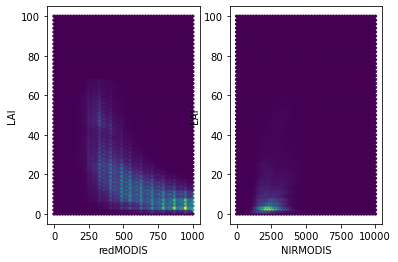

In [28]:
# trim data based on comparing Landsat and MODIS equivalents
# note we oversample the MODIS axis as we trim
# this takes some time

# histogram NDVI vs LAI
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.hexbin(unsatDF_NA['redMODIS'],unsatDF_NA['red'], gridsize=(50,50), extent=(0,1000,0,1000))
ax1.set(xlabel='redMODIS', ylabel='red')
ax2.hexbin(unsatDF_NA['NIRMODIS'],unsatDF_NA['NIR'], gridsize=(50,50), extent=(0,10000,0,10000))
ax2.set(xlabel='NIRMODIS', ylabel='NIR')

# threshold based on red MODIS
trimSample = unsatDF_NA.drop(unsatDF_NA.loc[(unsatDF_NA['redMODIS']<100)].index.values)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.hexbin(trimSample['redMODIS'],trimSample['red'], gridsize=(50,50), extent=(0,1000,0,1000))
ax1.set(xlabel='redMODIS', ylabel='red')
ax2.hexbin(trimSample['NIRMODIS'],trimSample['NIR'], gridsize=(50,50), extent=(0,10000,0,10000))
ax2.set(xlabel='NIRMODIS', ylabel='NIR')


# trim based on red
trimSample = trimDF(trimSample,'redMODIS','red',[10,90],np.arange(0.0,1000.0,10),np.arange(0,1000,10)*0+20)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.hexbin(trimSample['redMODIS'],trimSample['red'], gridsize=(50,50), extent=(0,1000,0,1000))
ax1.set(xlabel='redMODIS', ylabel='red')
ax2.hexbin(trimSample['NIRMODIS'],trimSample['NIR'], gridsize=(50,50), extent=(0,10000,0,10000))
ax2.set(xlabel='NIRMODIS', ylabel='NIR')

#trim based on nir
trimSample = trimDF(trimSample,'NIRMODIS','NIR',[10,90],np.arange(0.0,10000.0,100),np.arange(0,10000,100)*0+200)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.hexbin(trimSample['redMODIS'],trimSample['red'], gridsize=(50,50), extent=(0,1000,0,1000))
ax1.set(xlabel='redMODIS', ylabel='red')
ax2.hexbin(trimSample['NIRMODIS'],trimSample['NIR'], gridsize=(50,50), extent=(0,10000,0,10000))
ax2.set(xlabel='NIRMODIS', ylabel='NIR')

#trim based on nir
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.hexbin(trimSample['redMODIS'],trimSample['LAI'], gridsize=(50,50), extent=(0,1000,0,100))
ax1.set(xlabel='redMODIS', ylabel='LAI')
ax2.hexbin(trimSample['NIRMODIS'],trimSample['LAI'], gridsize=(50,50), extent=(0,10000,0,100))
ax2.set(xlabel='NIRMODIS', ylabel='LAI')

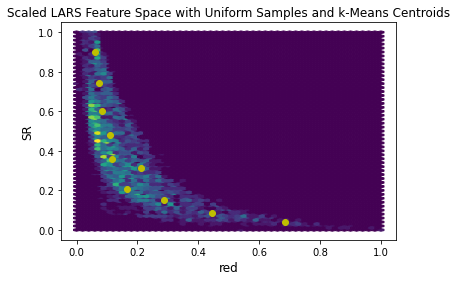

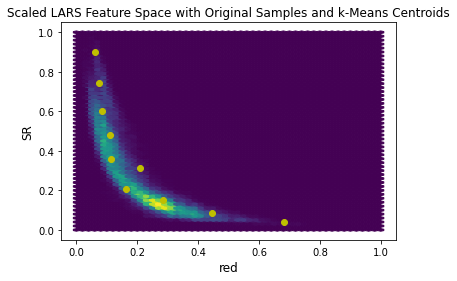

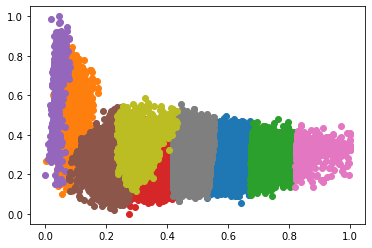

0.8271581070039141
0.920384341184383
0.8271819829345166
0.8531060722508228
0.9143865724730438
0.8049248358639562
0.7787576137234274
0.8357207742605716
0.8703039937140898


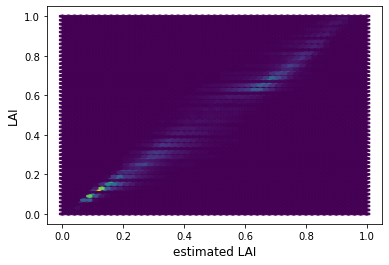

In [25]:

# process each biome type separately
for LC_type3 in [6]: #unsatDF_NA["LC_type3"].drop_duplicates():
#     #subset sample
#     sample = trimSample[trimSample["LC_type3"]==LC_type3]
#     print(len(sample))
    
#     # add ISR and SR 
#     sample['ISR'] = np.clip((sample.loc[:,"NIR"])/np.maximum(sample.loc[:,"SWIR1"],1),0,3)
#     sample['SR'] = np.clip((sample.loc[:,"NIR"])/np.maximum(sample.loc[:,"red"],1),0,20)
    
#     # trim based on LAI vs VIs
#     # we oversample in LAI
#     fig, (ax1, ax2) = plt.subplots(1,2)
#     ax1.hexbin(sample['LAI'],sample['SR'], gridsize=(50,50), extent=(0,100,0,20))
#     ax1.set(xlabel='LAI', ylabel='SR')
#     ax2.hexbin(sample['LAI'],sample['ISR'], gridsize=(50,50), extent=(0,100,0,3))
#     ax2.set(xlabel='LAI', ylabel='ISR')
#     trimSample2 = trimDF(sample,'LAI','SR',[1,99],np.arange(0.0,100.0,10),np.arange(0,100,10)*0+10)
#     trimSample2 = trimDF(sample,'LAI','ISR',[1,99],np.arange(0.0,100.0,10),np.arange(0,100,10)*0+10)
    
#     # see results 
#     fig, (ax1, ax2) = plt.subplots(1,2)
#     ax1.hexbin(trimSample2['LAI'],trimSample2['SR'], gridsize=(50,50), extent=(0,100,0,20))
#     ax1.set(xlabel='LAI', ylabel='SR')
#     ax2.hexbin(trimSample2['LAI'],trimSample2['ISR'], gridsize=(50,50), extent=(0,100,0,3))
#     ax2.set(xlabel='LAI', ylabel='ISR')
#     fig, (ax1, ax2) = plt.subplots(1,2)
#     ax1.hexbin(trimSample2['redMODIS'],trimSample2['red'], gridsize=(50,50), extent=(0,1000,0,1000))
#     ax1.set(xlabel='redMODIS', ylabel='red')
#     ax2.hexbin(trimSample2['NIRMODIS'],trimSample2['NIR'], gridsize=(50,50), extent=(0,10000,0,10000))
#     ax2.set(xlabel='NIRMODIS', ylabel='NIR')   
    
#     # add a lot of VIs (francis)
#     listVI = [ 'red','NIR','SWIR1','SR','ISR']
    
#     # standardize or rescale the data (probably rescale based on 1,99 %ile range since data is skewed)
#     scalerSample = MinMaxScaler().fit(trimSample2)
#     scaledSample = pd.DataFrame(scalerSample.transform(trimSample2),columns = trimSample2.columns, index =trimSample2.index)

#     # see results
#     fig, (ax1, ax2) = plt.subplots(1,2)
#     ax1.hexbin(scaledSample['LAI'],scaledSample['SR'], gridsize=(50,50), extent=(0,1,0,1))
#     ax1.set(xlabel='LAI', ylabel='SR')
#     ax2.hexbin(scaledSample['LAI'],scaledSample['ISR'], gridsize=(50,50), extent=(0,1,0,1))
#     ax2.set(xlabel='LAI', ylabel='ISR')
#     fig, (ax1, ax2) = plt.subplots(1,2)
#     ax1.hexbin(scaledSample['redMODIS'],scaledSample['red'], gridsize=(50,50), extent=(0,1,0,1))
#     ax1.set(xlabel='redMODIS', ylabel='red')
#     ax2.hexbin(scaledSample['NIRMODIS'],scaledSample['NIR'], gridsize=(50,50), extent=(0,1,0,1))
#     ax2.set(xlabel='NIRMODIS', ylabel='NIR')  
    


#     # initial data
#     plt.hexbin(scaledSample['SR'],scaledSample['LAI'], gridsize=(50,50), extent=(0,1,0,1))
#     plt.xlabel('SR',size = 12)
#     plt.ylabel('LAI',size = 12)
#     plt.show() 
    

          
# #     # do a coarse uniform subsample  VIs
#     featureColumns = listVI + ['LAI']
#     # get pdf of pairwise distances amd use x%ile 
#     di = pairwise_distances(scaledSample.sample(10000)[featureColumns])
#     di = np.amin(di+np.diag(np.ones(di.shape[0])+100),axis=1)

    
#     plt.hist(di)
#     plt.show()    
#     pairwiseDist = np.percentile(di,99)
#     numDim = len(featureColumns)
#     newSample  = scaledSample.iloc[0:1]
#     leafSize = 10
#     print(np.uint8(np.floor(np.log2(np.power(pairwiseDist,-numDim)))))
#     for i in range(1,2):
#         randSeed = LC_type3 + i
#         newSample = pd.concat([newSample,sobolSampler(scaledSample,featureColumns,leafSize,randSeed,numDim,pairwiseDist)])
#         print(len(newSample))   
#     plt.hexbin(newSample['SR'],newSample['LAI'], gridsize=(50,50), extent=(0,1,0,1))
#     plt.xlabel('SR',size = 12)
#     plt.ylabel('LAI',size = 12)
#     plt.title('Scaled SR vs LAI  with Uniform Samples before LARS')
#     plt.show()    
    
#     # do lars to select a subset of good vis (you can visualize bu using show LarsPath or actually get the model using (e.g. we use 2 so we can visualize easily) 
    # alphas, active, coefs = showLarsPath(newSample[listVI].to_numpy(),newSample['LAI'].to_numpy())
    # listVI = [listVI[i] for i in np.uint64(np.subtract(np.where(coefs[:,2]>0),1))[0]]
    # print(listVI)
    
    # do a coarse uniform subsample for lars  VIs
    # featureColumns = listVI + ['LAI']
    # # get pdf of pairwise distances amd use x%ile 
    # di = np.amin(pairwise_distances(scaledSample.sample(10000)[featureColumns])+np.diag(np.ones(di.shape[0])+100),axis=1)
    # plt.hist(di)
    # plt.show()    
    # pairwiseDist = np.percentile(di,99)
    # numDim = len(featureColumns)
    # newSample  = scaledSample.iloc[0:1]
    # leafSize = 10
    # # just do one set of random samples 
    # for i in range(1,2):
    #     newSample = pd.concat([newSample,sobolSampler(scaledSample,featureColumns,leafSize,randSeed,numDim,pairwiseDist)])
    #     print(len(newSample))   
    # plt.hexbin(newSample['SR'],newSample['LAI'], gridsize=(50,50), extent=(0,1,0,1))
    # plt.xlabel('SR',size = 12)
    # plt.ylabel('LAI',size = 12)
    # plt.title('Scaled SR vs LAI  with Uniform Samples after LARS')
    # plt.show()    

        
#     # do kmeans with only a M clusters on the lars subset and visualize
    numClusters = 10
    kmeans = KMeans(n_clusters=numClusters, random_state=0).fit(newSample[listVI])
    plt.hexbin(newSample[listVI[0]],newSample[listVI[1]], gridsize=(50,50), extent=(0,1,0,1))
    plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='y')
    plt.xlabel(listVI[0],size = 12)
    plt.ylabel(listVI[1],size = 12)
    plt.title('Scaled LARS Feature Space with Uniform Samples and k-Means Centroids')
    plt.show() 

    plt.hexbin(scaledSample[listVI[0]],scaledSample[listVI[1]], gridsize=(50,50), extent=(0,1,0,1))
    plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='y')
    plt.xlabel(listVI[0],size = 12)
    plt.ylabel(listVI[1],size = 12)
    plt.title('Scaled LARS Feature Space with Original Samples and k-Means Centroids')
    plt.show() 
    from sklearn.ensemble import RandomForestRegressor

    # label allsamples by cluster which can now be treated as inputs for each tree
    # ideallyy we would add in a bit of adjacent cluster - not sure how to do this easily
    scaledSample['cluster1'] = kmeans.predict(scaledSample[listVI])
    for i in range(1,numClusters):
        plt.scatter(scaledSample.loc[scaledSample['cluster1']==i]['SR'],scaledSample.loc[scaledSample['cluster1']==i]['SWIR1'])
    plt.show()
    

    # make a regression tree for each cluster and predict (for now no testing dataset ... )
    # we assume for now each cluster sufficiently uniform and we use all VIs
    # we coyuld always resort to lars or both but a RF is generally robust to lots of features 
    YY = []
    yy = []
    for i in range(1,numClusters):
        X = scaledSample.loc[scaledSample['cluster1']==i,[ 'red','NIR','SWIR1','SR','ISR']]
        y = np.ravel(np.array(scaledSample.loc[scaledSample['cluster1']==i,['LAI']]))
        clf = RandomForestRegressor(random_state=0).fit(X,y)
        print(clf.score(X,y))
        YY.append(clf.predict(X))
        yy.append(y)
    YY = [item for sublist in YY for item in sublist]
    yy = [item for sublist in yy for item in sublist]
    plt.hexbin(YY, yy, gridsize=(50,50), extent=(0,1,0,1))
    plt.xlabel('estimated LAI',size = 12)
    plt.ylabel('LAI',size = 12)
    plt.show()      
            


        